<a href="https://colab.research.google.com/github/miloszp2223/ZadanieML/blob/master/Zadanie2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 8.8 MB/s  0:00:01.8 MB/s eta 0:00:01:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [ucimlrepo]━ 2/4 [pandas]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import torch
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score


import torch
import torch.nn as nn
import torch.optim as optim

## Wyzwanie
Perceptron dla obecnych sieci neuronowych jest jak Australopitek dla Homo sapiens - możemy się śmiać, że sieć kiedyś była taka prymitywna, ale bez zrozumienia niej - nie zrozumiemy całego skomplikowania nowoczesnych architektur. Twoim zadaniem będzie implementacja perceptronu, a także jego nauka od zera. Wyniki zweryfikujesz implementując na końcu taką samą sieć w [Pytorchu](https://docs.pytorch.org/docs/stable/index.html).

## Jak zrobić zadanie
0. Dane są te same co w poprzednim zadaniu - [Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
1. Wykorzystaj wiedzę z poprzedniego notebooka (jak i kod, jeśli się da) do przygotowania danych. Pamiętaj o podziale na zbiory train, val i test. Przeskaluj dane używając StandardScaler lub innych, oczywiście unikając wycieku danych.
2. Możecie ograniczyć się do dwóch cech wejściowych - wybranych wedle uznania - do celów zadania (np. dwie cechy łatwiej jest zwizualizować)
3. Niżej są podane instrukcje (symbol ⚡ oznacza, że coś trzeba zaimplementować) - najlepiej rób je sekwencyjnie.

przydatne materiały:
* [deep_learning_60min_blitz](https://docs.pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html),
* [zrozumienie under/overfitting](https://mlu-explain.github.io/bias-variance/),
* [SUPER tutorial(e)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html),
* [Mathematics of neural networks in machine learning](https://en.wikipedia.org/wiki/Mathematics_of_neural_networks_in_machine_learning),
* [Pozycja 53 -> rozdziały 2 (fenomenalny),11](https://docs.google.com/spreadsheets/d/1UnjOh5TYgNiFBw9jsM6mJrp68uEdzeW3iIi6Ew0xfgQ/edit?gid=0#gid=0),
* [Optymizatory & uczenie paczkami](https://arxiv.org/pdf/1609.04747)


### Problemy w uczeniu maszynowym

Przypomnijmy sobie jeszcze czym się różni zadanie **klasyfikacji** od **regresji**. Jak już zapewne wiesz, nasze dane można podzielić na zbiór cech (X) oraz na zbiór zmiennych docelowych (y). Ten drugi może kodować informacje o tym, jaka jest klasa przynależności (np. *chory ∈ {true, false}*, *kolor ∈ {zielony, niebieski, czerwony}*), lub jaka jest wartość pewnej cechy (np. *temperatura ∈ ℜ*, *punkty z egzaminu* ∈ 𝒵). W zadaniu klasyfikacji mamy do czynienia z kategoriami, które są dyskretne, a w zadaniu regresji zmienne docelowe są zwykle ciągłe. Dlaczego to istotne? W trakcie pracy nad notebookiem pewnie zdasz sobie sprawę, że nie można do problemu klasyfikacji użyć straty najmniejszych kwadratów - co byłoby odpowiednie w problemie regresji.

## 1. Perceptron*
Wejdziemy w trochę matematyki (serio, matma jest niezbędna jeśli chcesz być Pro AI engineer'em). Najprostszy perceptron opisany jest wzorem

$$A = σ(𝑤^TX + b) = σ(Z) = (a_1, ..., a_{m-1})$$
gdzie


*   σ to funkcja aktywacji
*   $X$ to macierz cech, wymiaru $k \times m$ ($=$ liczba cech $\times$ liczba próbek)
*   𝑤 to macierz wag z $k$ wartościami (wyuczalne parametry)
*   b to skalar, zwany *biasem* (wyuczalny parametr)
*   $A$ to wyjściowy wektor o długości $m$

Popularne funkcje aktywacji:
- Relu: $f(Z) = max(Z, 0)$
- Sigmoid: $f(Z) = \frac{1}{1 + e^{-Z}}$

Jednak w tym zadaniu poprawna będzie tylko jedna - musisz sam(a) wybrać która to będzie i dlaczego. (Hint: zastanów się, *co oznacza wyjście sieci*, i dlaczego ta "niepoprawna" funkcja aktywacji będzie psuła sieć)

*W rzeczywistości nie będzie to [stricte perceptron](https://pl.wikipedia.org/wiki/Perceptron), ponieważ nie będziemy implementować skokowej funkcji straty.

##odpowiedź:
Tutaj poprawny będzie Sigmoid, ponieważ y ma wartości binarne. Jeżeli użyta zostałaby funkcja Relu nie mielibyśmy rzutowania na wynik i nie dałoby się go interpretować.

Przygotowanie danych, zdecydowałem się użyć zmiennych numerycznych.

In [3]:
bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
X = X[['age', 'balance', 'campaign', 'pdays', 'previous']].to_numpy()
y = bank_marketing.data.targets['y'].map({'yes': 1, 'no': 0}).to_numpy()
y = y.astype(float)
print(X)
print(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12, stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



[[  58 2143    1   -1    0]
 [  44   29    1   -1    0]
 [  33    2    1   -1    0]
 ...
 [  72 5715    5  184    3]
 [  57  668    4   -1    0]
 [  37 2971    2  188   11]]
[0. 0. 0. ... 1. 0. 0.]
(36168, 5) (9043, 5) (36168,) (9043,)


<span style="color:red">brak podstawowej obróbki danych wyzucelnie NaN, normalziacja danych. Dzialanie tylko na 5 danych nie jest dobre</span>


### ⚡ Zaimplementuj tutaj perceptron

In [4]:
class Perceptron:

  def __init__(self, weight_count: int):
        self.weights = np.random.randn(weight_count) * 0.01
        self.bias = 0.0

  def sigmoid(self, Z):
        Z = np.clip(Z, -500, 500)  # zapobiega overflow
        return 1 / (1 + np.exp(-Z))

  def forward(self, X: np.ndarray):
        self.Z = np.dot(X, self.weights) + self.bias
        self.A = self.sigmoid(self.Z)
        return self.A

perceptron = Perceptron(weight_count=5)
print(perceptron.forward(X_train))

[0.49985084 0.50365377 0.49692797 ... 0.49018586 0.50126384 0.50083831]


### Przejście w przód i w tył

Następnym zadaniem jest wyuczenie naszych macierzy. Prawdopodobnie twoje wartości są losowe (mam nadzieję, że macierz nie jest wypełniona zerami), przez co i sieć daje losowe wyniki. To, co możemy wydzielić jako atomową operację w procesie uczenia sieci składa się z kroków:
1. Forward propagation (przejście w przód) - wymnożenie wejściowych cech przez wagi sieci
2. Loss (obliczanie straty) - obliczamy jaki jest błąd popełniany przez sieć
3. Backward propagation (przejście w tył) - propagacja gradientu i **aktualizacja** wag sieci

Proces uczenia zachodzi w N epokach.

Pytanie filozoficzne: czy strata może być równa zero? czy możemy wyczyć idealną sieć? Jak sądzisz, w jakich warunkach tak może być? (warto na takie przemyślenie poświęcić >=30 sekund).

Matematycznie ma to taką postać:
* Fp: $A = σ(𝑤^TX + b) = σ(Z)$ (to było już)
* Loss: L = $\frac{1}{M} g(A, Gt)$, gdzie $Gt$ to prawdziwe, poprawne wartości, a $g$ to odpowiednia dla problemu funkcja straty. Dzielimy przez liczbę próbek, bo chcemy uzyskać średnią wartość błędu,
* Bp: niestety nie zachodzi w jednym kroku. Rozpiszmy to

$$L = \frac{1}{M} g(A, Gt)$$  -> mamy nasz wyliczony loss (musimy mieć wartość skalarną, dlatego uśredniamy startę)
$$\frac{∂L}{∂𝑤} = ? $$ -> to chcemy wyliczyć (zaraz, zaraz powiemy po co)
$$ \frac{∂L}{∂𝑤} = \frac{∂L}{∂A} \frac{∂A}{∂Z} \frac{∂Z}{∂w}$$ -> to wynika z [twierdzenia łańcuchowego](https://en.wikipedia.org/wiki/Chain_rule)

Jaki mamy deal z tego? Otóż będziemy obliczać pochodne zmiany funkcji starty względem parametrów sieci tak, by je dostosowywać w kierunku zmniejszenia się tej straty (spadek wzdłuż gradientu [link text](https://en.wikipedia.org/wiki/Gradient_descent)). Aktualizacja wag sieci, w epoce n, ma postać:

$$𝑤^{n + 1} = 𝑤^{n} - \alpha \frac{∂L}{∂𝑤}$$

gdzie $\alpha$ jest hiperparameterem (czyli taką wartością, która jest ustalana z góry, przed uruchomieniem treningu), zwykle o wartościach $0.01$, czy $0.001$.
 Decyduje ona o szybkości treningu.

 Twoim zadaniem jest teraz ⚡ implementacja klasy do trenowania, dla której docelowo chcemy tylko wywołać funkcję *train*, a w środku ma zachodzić cała magia. Funkcja *predict* ma służyć do predykcji kategorii dla próbek testowych.

Wybrałem BCE, ponieważ używa się jej dla problemów binarnej klasyfikacji.

In [5]:
class Trainer:

  def __init__(self, perceptron: Perceptron, n_epochs: int, lr: float):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.lr = lr


  def loss(self, A: np.array, y: np.ndarray): # oblicza stratę między wyjściem sieci a ground truth
    return np.mean(-y * np.log(A) - (1 - y) * np.log(1 - A))

  def backward(self, X: np.ndarray, y: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    m = X.shape[0]
    dZ = self.perceptron.A - y
    self.dW = (1 / m) * np.dot(X.T, dZ) #wagi
    self.db = (1 / m) * np.sum(dZ) #bias


  def update_weights(self): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    self.perceptron.weights -= self.lr * self.dW
    self.perceptron.bias -= self.lr * self.db


  def train(self, X: np.ndarray, y: np.ndarray): # wykonuje trenowanie w N epokach
    for epoch in range(self.n_epochs):
        A = self.perceptron.forward(X)
        self.loss(A, y)
        self.backward(X, y)
        self.update_weights()

  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    A = self.perceptron.forward(X)
    return (A >= 0.5).astype(int)


trainer = Trainer(
    perceptron=perceptron,
    n_epochs=10000,
    lr=0.01
)

trainer.train(X_train, y_train)


<span style="color:red">jakiś plot statystyk by się przydał</span>


## HINTS
Hint1: na kartce rozpisz sobie krok po kroku przejście w przód. Najlepiej użyj tej samej konwencji nazewniczej zmiennych, lub zdefiniuj zmienne pomocniczne. Rozwiń jaki będzie konkretny wzór na pochodne: $\frac{∂L}{∂A}$, $\frac{∂A}{∂z}$ i  $\frac{∂z}{∂w}$. Jak już przez to przebrniesz, to przepisanie tego do Pythona powinno być bezbolesne i skuteczne.

Hint2: Funkcje straty, które powinieneś/powinnaś rozważać to [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) lub [BCE](https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/). Jeśli rozpisanie gradientu jest dla ciebie nie do przejścia, to posłuż się "gotowcem", ale nadal spróbuj samodzielnie przepisać na kod.

Hint3: do mnożenia macierzy w numpy używamy ```np.dot``` lub ```@```.

Hint4: początkowe wartości macierzy $𝑤$ mogą być zaincjalizowane losowymi wartościami z niewielkiego zakresu (np. $[-0.01, 0.01]$)

Hint5: wartości wejściowe powinny być ustandaryzowane (dla poprawy jakości spadku wzdłuż gradientu)

### Uczenie paczkami
Być może już zauważyłeś/łaś, że wymnażanie wielkiej macierzy $X$ w pojedynczym kroku jest problematyczne - jeśli nie w tym eksperymencie, to w następnym. Istnieją różne strategie do aktualizacji parametrów:
* batch gradient descent - aktualizacja parametrów odbywa się po przejściu wszystkich próbek przez sieć, a gradient jest uśredniany (to, co pewnie masz teraz)
* stochastic gradient descent - aktualizacja parametrów następuje po każdej pojedynczej próbce (podejście na drugim końcu spektrum)
* mini-batch stochastic gradient descent - podział wszystkich próbek na paczki o wielkości $M$, i aktualizacja gradientu po każdej paczce (podejście "po środku" dwóch poprzednich)

Zastanów się, które podejście jest odpowiednie i w funkcji *train* ⚡ doimplementuj odpowiedni podział (lub nie?) macierzy danych $X$.

Nic nie stoi na przeszkodzie, by udokumentować zachowanie sieci dla każdej strategii (możesz to zawrzeć w dalszej sekcji eksperymentów).


### Śledzenie przebiegu uczenia

W praktyce, sam spadek wzdłuż gradientu nie gwarantuje, że dostaniemy optymalne wagi sieci. W celu weryfikacji, czy nie doszło do **przeuczenia**, twoim ⚡ kolejnym krokiem będzie dodanie do klasy *Trainer* funkcji, które zapiszą, na końcu każdej epoki

 (a) istotne metryki w kontekście zadania,

(b) wartość straty

zarówno dla zbioru treningowego, jak i walidacyjnego - najlepiej w postaci wykresu. Na ich podstawie zdiagnozuj, czy model podlega **niedouczeniu / underfitting**, **przeuczeniu / overfitting**, a może jest względnie "dobry".  

In [6]:
class Trainer:

  def __init__(self, perceptron: Perceptron, n_epochs: int, lr: float):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.lr = lr
    self.train_loss_history = []
    self.val_loss_history = []
    self.train_acc_history = []
    self.val_acc_history = []
    self.train_prec_history = []
    self.val_prec_history = []
    self.train_rec_history = []
    self.val_rec_history = []


  def loss(self, A: np.array, y: np.ndarray): # oblicza stratę między wyjściem sieci a ground truth
    eps = 1e-8 #zabezpieczenie przed /0
    return -np.mean(y * np.log(A + eps) + (1 - y) * np.log(1 - A + eps))

  def backward(self, X: np.ndarray, y: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    m = X.shape[0]
    dZ = self.perceptron.A - y
    self.dW = (1 / m) * np.dot(X.T, dZ) #wagi
    self.db = (1 / m) * np.sum(dZ) #bias


  def update_weights(self): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    self.perceptron.weights -= self.lr * self.dW
    self.perceptron.bias -= self.lr * self.db


  def train(self, X_train: np.ndarray, y_train: np.ndarray,  X_val=None, y_val=None, batch_size=128): # wykonuje trenowanie w N epokach
    n_samples = X_train.shape[0]

    for epoch in range(self.n_epochs):#mini batch
      perm = np.random.permutation(n_samples)
      X_shuffled = X_train[perm]
      y_shuffled = y_train[perm]

      for i in range(0, n_samples, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        self.perceptron.forward(X_batch)
        self.backward(X_batch, y_batch)
        self.update_weights()

      # Zbieranie danych co 10 epokę
      if (epoch+1)%10 == 0:
        train_loss, train_acc, train_prec, train_rec  = self.collect_data(X_train, y_train)
        self.train_loss_history.append(train_loss)
        self.train_acc_history.append(train_acc)
        self.train_prec_history.append(train_prec)
        self.train_rec_history.append(train_rec)

        if X_val is not None and y_val is not None:
            val_loss, val_acc, val_prec, val_rec = self.collect_data(X_val, y_val)
            self.val_loss_history.append(val_loss)
            self.val_acc_history.append(val_acc)
            self.val_prec_history.append(val_prec)
            self.val_rec_history.append(val_rec)
        else:
            val_loss, val_acc, val_prec, val_rec = None, None, None, None




  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    A = self.perceptron.forward(X)
    return (A >= 0.3).astype(int)

  def collect_data(self, X, y):
    A = self.perceptron.forward(X)
    loss = self.loss(A, y)

    y_pred = (A >= 0.3).astype(int)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)

    return loss, acc, prec, rec

  def plot_metrics(self):
      plt.figure(figsize=(18,5))

      #oś x
      x = np.arange(len(self.train_acc_history)) * 10


      # Loss
      plt.subplot(1,4,1)
      plt.plot(x, self.train_loss_history, label='Train Loss')
      if self.val_loss_history:
          plt.plot(x, self.val_loss_history, label='Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('BCE Loss')
      plt.title('Loss plot')
      plt.legend()

      # Accuracy
      plt.subplot(1,4,2)
      plt.plot(x, self.train_acc_history, label='Train Acc')
      if self.val_acc_history:
          plt.plot(x, self.val_acc_history, label='Validation Acc')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.title('Accuracy plot')
      plt.legend()

      # Precision
      plt.subplot(1,4,3)
      plt.plot(x, self.train_prec_history, label='Train Prec')
      if self.val_prec_history:
          plt.plot(x, self.val_prec_history, label='Validation Prec')
      plt.xlabel('Epoch')
      plt.ylabel('Precision')
      plt.title('Precision plot')
      plt.legend()

      # Recall
      plt.subplot(1,4,4)
      plt.plot(x, self.train_rec_history, label='Train Rec')
      if self.val_rec_history:
          plt.plot(x, self.val_rec_history, label='Validation Rec')
      plt.xlabel('Epoch')
      plt.ylabel('Recall')
      plt.title('Recall plot')
      plt.legend()

      plt.suptitle(f'lr: {self.lr} epochs: {self.n_epochs}')
      plt.show()


### ⭐ Ekstra zadanie - optymizator
Spadek wzdłuż gradientu zawsze bierze pod uwagę tylko aktualne wartości gradientów, przez co może być podatny na gwałtowne zmiany. W celu wydajniejszego trenowania stosuje się [optymizatory](https://arxiv.org/pdf/1609.04747) typu *Momentum* czy *Adagrad* (choć w praktyce zwykle *Adam*). Zaimplementuj wybrany optimzator i porównaj, jak uczy się sieć z i bez, oraz jak zmieniają się wartości wag (np. możesz logować bezwzględną, uśrednioną wartość zmian wag).

### ⚡ Eksperymenty
Zbadaj skuteczność sieci oraz oceń, czy dobrze się generalizuje na podstawie krzywych uczenia. Dokładniej, zbadaj co najmniej **3 wartości współczynnika uczenia** i **3 wartości liczby epok**. Zapisz swoje obserwacje. Nie przejmuj się, jeśli po nieudanych próbach twoja sieć nie chce się uczyć - jeśli czujesz, że wiesz w czym leży błąd, to zapisz te obserwacje.

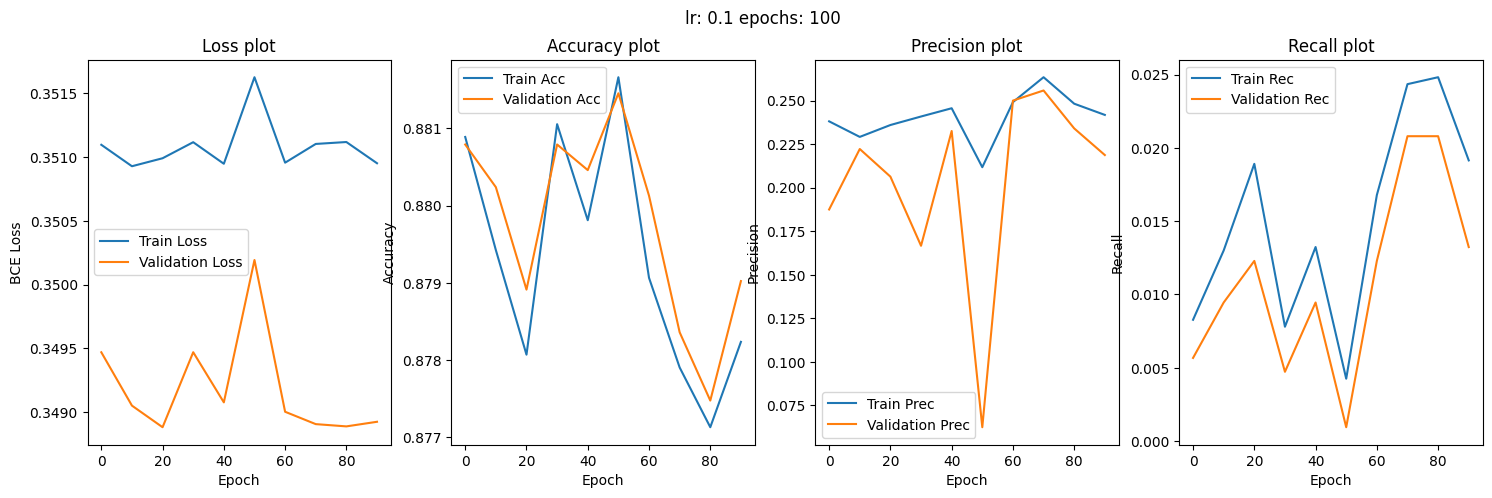

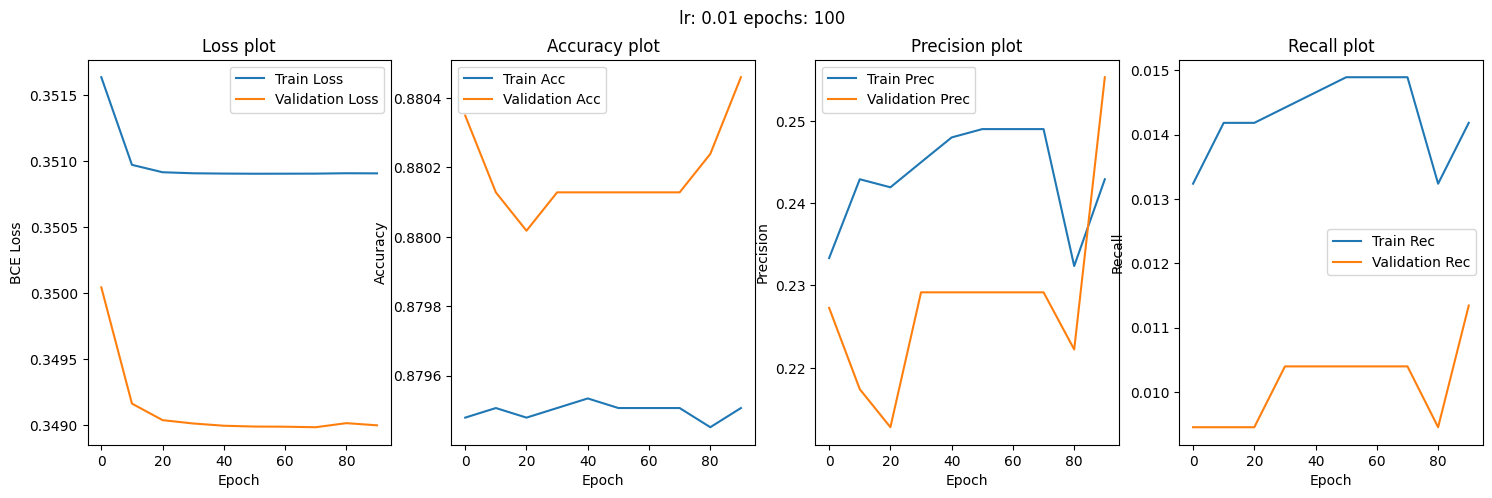

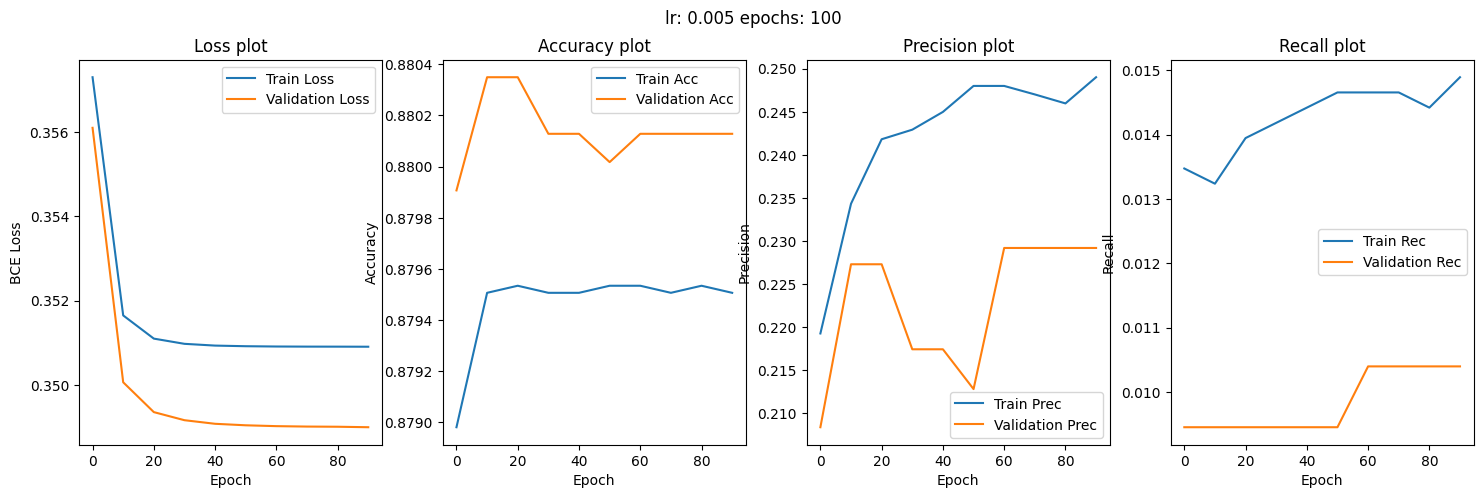

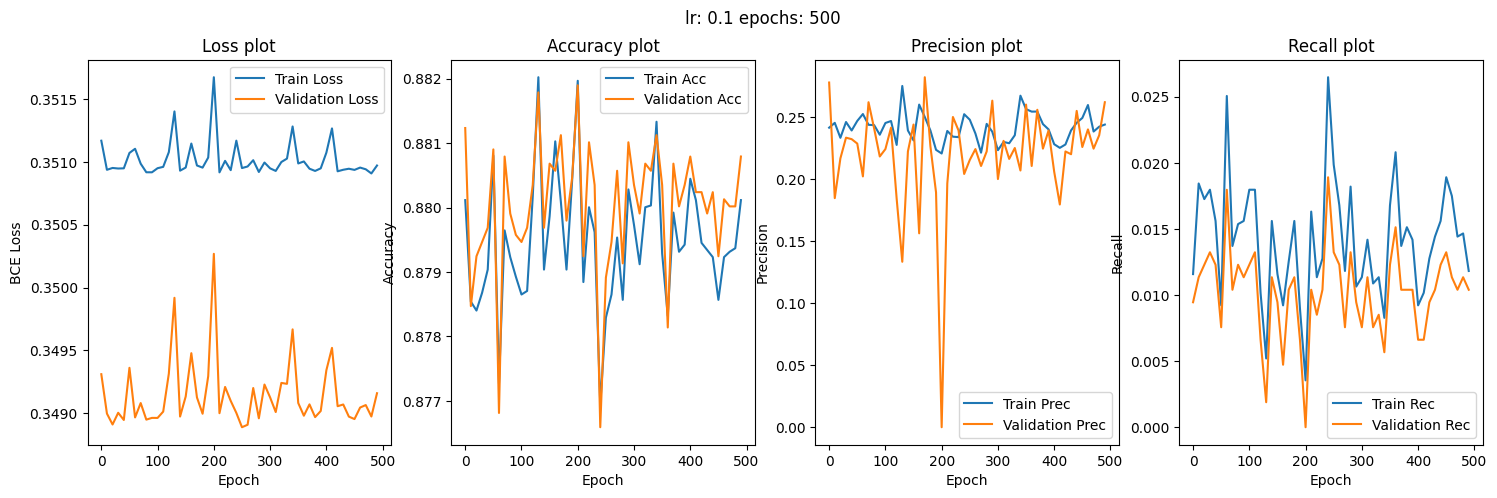

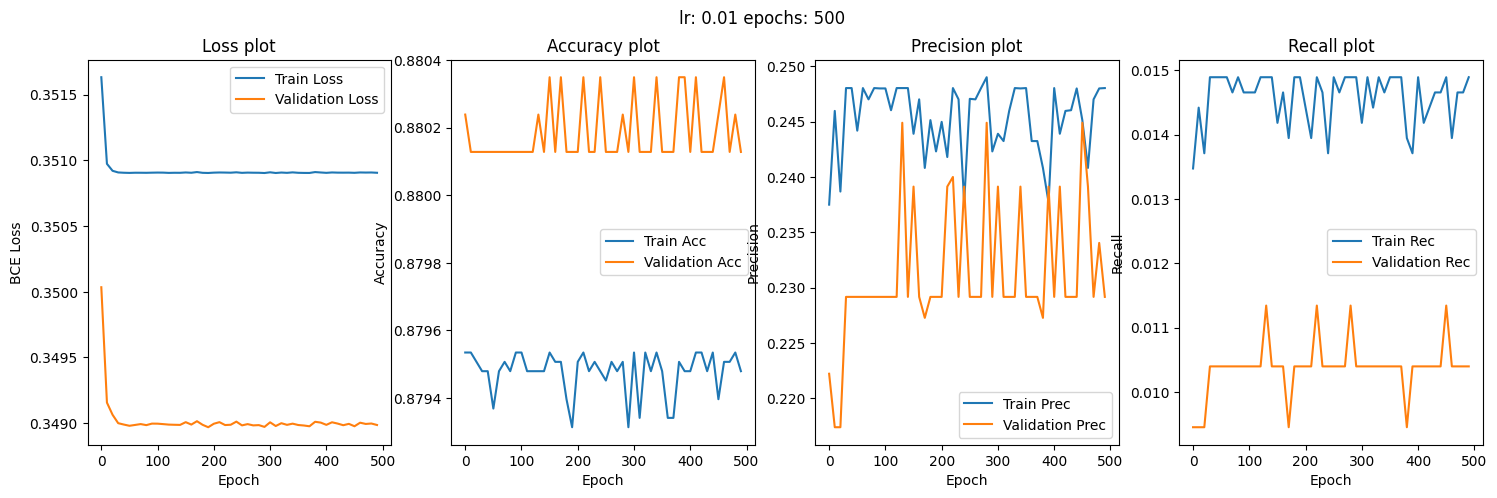

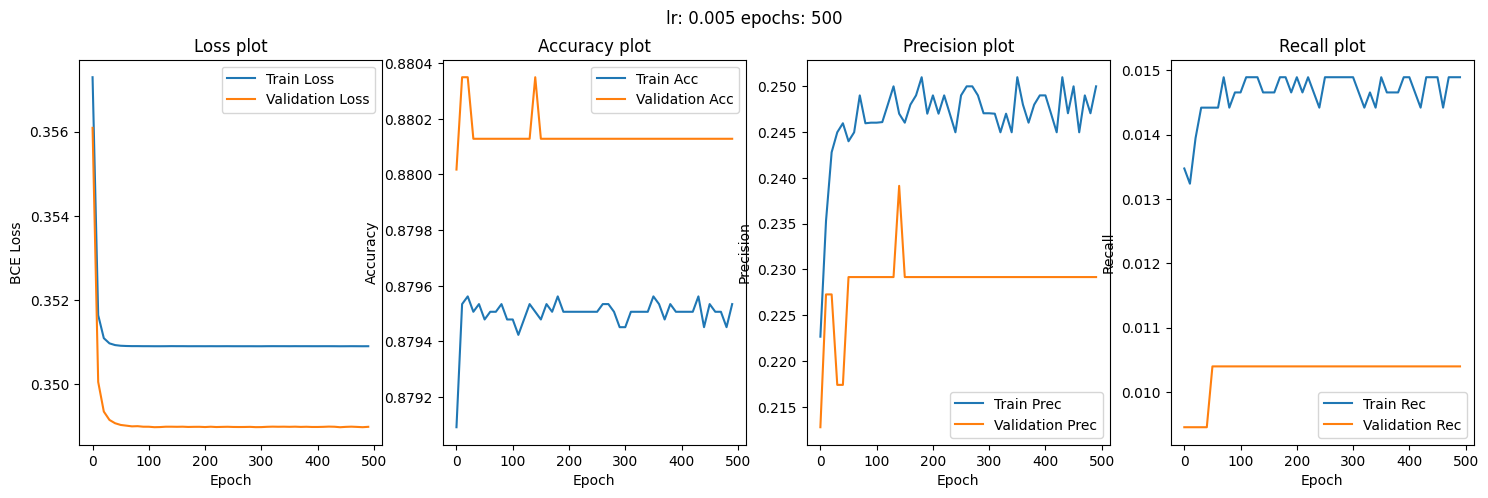

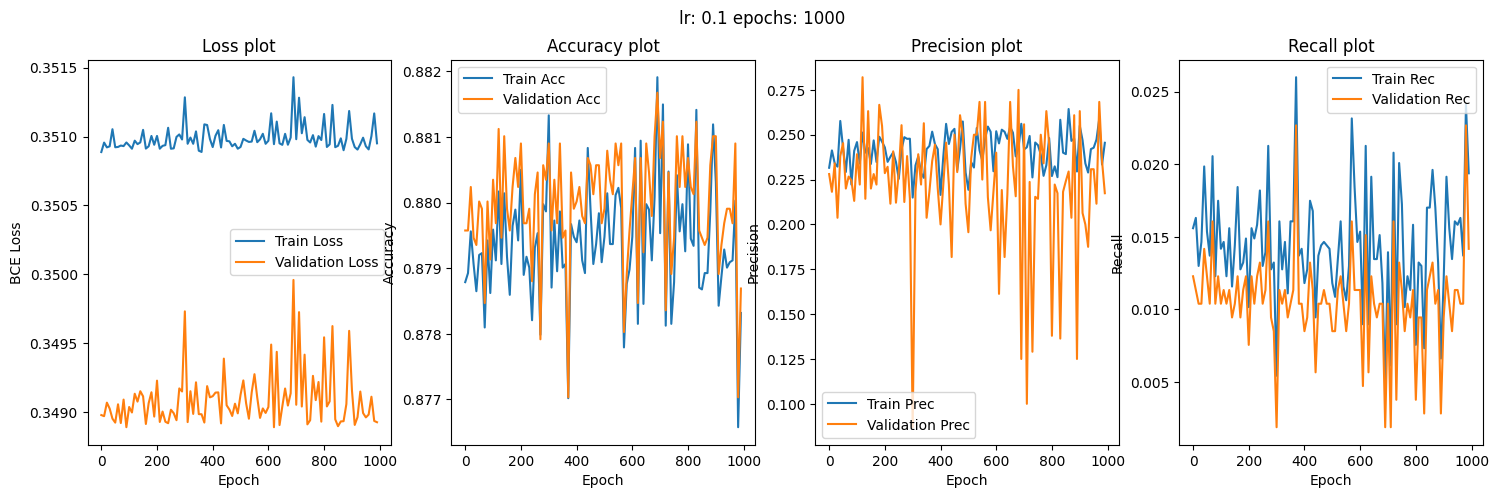

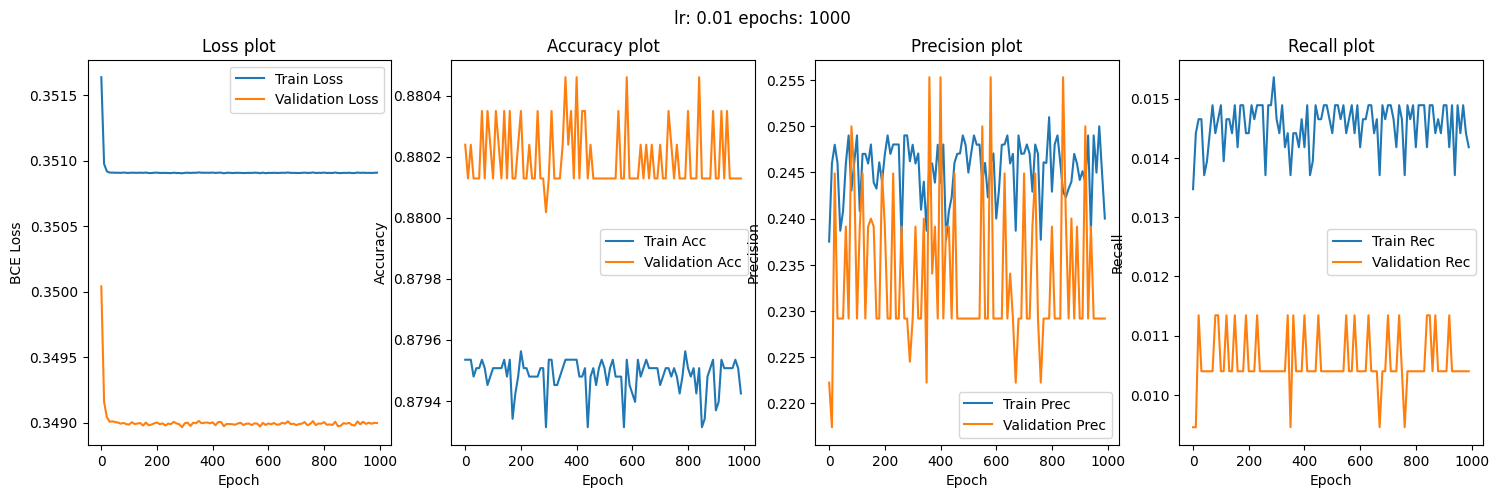

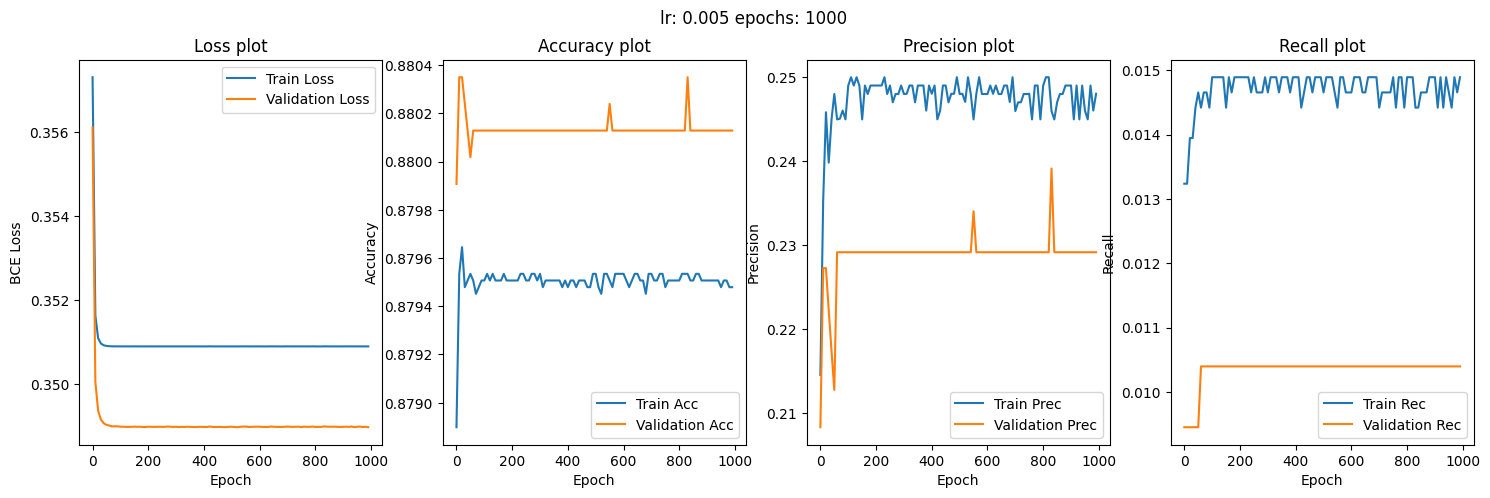

In [7]:
def test(n_epochs, lr):
  for epoch in n_epochs:
    for l in lr:
      perceptron = Perceptron(weight_count=5)

      trainer = Trainer(
          perceptron=perceptron,
          n_epochs=epoch,
          lr=l
      )

      trainer.train(X_train, y_train, X_test, y_test)
      #print(np.sum(trainer.predict(X_test) == 1))
      trainer.plot_metrics()

lr_list = [0.1, 0.01, 0.005]
epoch_list = [100, 500, 1000]

test(epoch_list, lr_list)

Model prawie w ogóle się nie uczy. Poza tym praktycznie zawsze daje odpowiedź 1, więc wydaje mi się że problem wynika głównie z niezbalansowania datasetu(około 90% odpowiedzi 0).
Zmiana progu decyzyjnego z 0.5 na 0.3 trochę poprawiła wyniki (model zaczął okazjonalnie dawać i trafiać 1), ale i tak działa słabo.
Wykresy dla całego batcha na raz były na ogół dość proste, natomiast dla mini-batcha jak widać powyżej wykresy mają bardzo zmienne wartości.

## 2. Implementacja sieci w pytorchu
Następnie ⚡ zaimplementujesz perceptron korzystając z biblioteki pytorch w celu weryfikacji wyników.

### Tensory
Są to struktury danych zbliżone do macierzy **np.array**, tyle, że mogą być przenoszone na karty graficzne, które są niezbędne do wyuczenia głębokich sieci. W następującej części zadania będziesz musiał(a) opanować pracę z tensorami i ich zamianę z i do tablicy NumPy.

In [9]:
data_list = [[2, 5], [3, 6],[4, 7]]
numpy_array = np.array(data_list) # tablica numpy utworzona z listy
data_tensor = torch.from_numpy(numpy_array) # tensor utworzony z tablicy numpy
print(data_tensor.shape) # kształt tensora
data_tensor

torch.Size([3, 2])


tensor([[2, 5],
        [3, 6],
        [4, 7]])

### Perceptron w torchu
Z wykorzystaniem biblioteki [torch.nn](https://docs.pytorch.org/docs/stable/nn.html) ⚡ zaimplementuj jednowarstwową sieć neuronową wraz z jej trenowaniem, z która porównasz swoją sieć zbudowaną w numpy. Przydatny może być tutorial [pytorch-nn](https://docs.pytorch.org/tutorials/beginner/pytorch_with_examples.html#learning-pytorch-with-examples). ⚡ Powtórz te same eksperymenty, które wykonane zostały dla twojego Perceptronu, oraz porównaj ze sobą wyniki. Zastanów się, skąd mogą wynikać różnice oraz dlaczego ostatecznie nie chcelibyśmy implementować sieci neuronowych w numpy 😅.


---


*Uwaga*: jeśli czujesz, że jest to dla ciebie zbyt proste, to skontruuj klasę wielowarstwowej sieci neuronowej do "prawdziwego" rozwiązania problemu (spróbuj wtedy wykorzystać (prawie) wszystkie kolumny).

*Uwaga do uwagi*: jeśli czujesz, że to nadal za mało, to przepisz sieć do frameworka [lightning](https://lightning.ai/docs/pytorch/stable/). Dodaj do tego logowanie w tensorboard.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

class Perceptron(nn.Module):
    def __init__(self, weight_count: int):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(weight_count, 1)

        # Wagi jak w poprzedniej implementacji
        nn.init.normal_(self.linear.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        linear_out = self.linear(x)
        return torch.sigmoid(linear_out)

In [11]:
class Trainer:
    def __init__(self, perceptron: Perceptron, n_epochs: int, lr: float):
        self.perceptron = perceptron.to(device)
        self.n_epochs = n_epochs
        self.lr = lr

        self.criterion = nn.BCELoss() #funkcja loss
        self.optimizer = optim.SGD(self.perceptron.parameters(), lr=self.lr)

        #dane do wykresów
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.train_prec_history = []
        self.val_prec_history = []
        self.train_rec_history = []
        self.val_rec_history = []

    def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val=None, y_val=None, batch_size=128):
        # Konwersja z Numpy na PyTorch Tensor
        X_train_t = torch.tensor(X_train, dtype=dtype, device=device)
        y_train_t = torch.tensor(y_train, dtype=dtype, device=device).view(-1, 1) # reshape na (N, 1)

        if X_val is not None:
            X_val_t = torch.tensor(X_val, dtype=dtype, device=device)
            y_val_t = torch.tensor(y_val, dtype=dtype, device=device).view(-1, 1)


        n_samples = X_train.shape[0]

        for epoch in range(self.n_epochs): #mini batch
            perm = np.random.permutation(n_samples)
            X_shuffled = X_train_t[perm]
            y_shuffled = y_train_t[perm]

            self.perceptron.train()

            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                #Zerowanie gradientów
                self.optimizer.zero_grad()
                #Forward
                outputs = self.perceptron(X_batch)

                loss = self.criterion(outputs, y_batch)
                loss.backward()
                #Aktualizacja wag
                self.optimizer.step()

            # Zbieranie danych co 10 epokę
            if (epoch + 1) % 10 == 0:
                train_loss, train_acc, train_prec, train_rec = self.collect_data(X_train_t, y_train_t)
                self.train_loss_history.append(train_loss)
                self.train_acc_history.append(train_acc)
                self.train_prec_history.append(train_prec)
                self.train_rec_history.append(train_rec)

                if X_val is not None:
                    val_loss, val_acc, val_prec, val_rec = self.collect_data(X_val_t, y_val_t)
                    self.val_loss_history.append(val_loss)
                    self.val_acc_history.append(val_acc)
                    self.val_prec_history.append(val_prec)
                    self.val_rec_history.append(val_rec)

    def predict(self, X: np.ndarray) -> np.ndarray:
        self.perceptron.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=dtype, device=device)
            outputs = self.perceptron(X_t)
            predicted = (outputs >= 0.3).int().cpu().numpy()

        return predicted

    def collect_data(self, X_t, y_t):
        self.perceptron.eval()
        with torch.no_grad():
            outputs = self.perceptron(X_t)
            loss = self.criterion(outputs, y_t).item()

            # Konwersja na cpu i numpy
            y_pred_np = (outputs >= 0.3).int().cpu().numpy()
            y_true_np = y_t.int().cpu().numpy()

            acc = accuracy_score(y_true_np, y_pred_np)
            prec = precision_score(y_true_np, y_pred_np, zero_division=0)
            rec = recall_score(y_true_np, y_pred_np, zero_division=0)

        return loss, acc, prec, rec

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        # Oś X (epoki)
        x = np.arange(len(self.train_acc_history)) * 10

        # Loss
        plt.subplot(1, 4, 1)
        plt.plot(x, self.train_loss_history, label='Train Loss')
        if self.val_loss_history:
            plt.plot(x, self.val_loss_history, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('BCE Loss')
        plt.title('Loss plot')
        plt.legend()

        # Accuracy
        plt.subplot(1, 4, 2)
        plt.plot(x, self.train_acc_history, label='Train Acc')
        if self.val_acc_history:
            plt.plot(x, self.val_acc_history, label='Validation Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy plot')
        plt.legend()

        # Precision
        plt.subplot(1, 4, 3)
        plt.plot(x, self.train_prec_history, label='Train Prec')
        if self.val_prec_history:
            plt.plot(x, self.val_prec_history, label='Validation Prec')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.title('Precision plot')
        plt.legend()

        # Recall
        plt.subplot(1, 4, 4)
        plt.plot(x, self.train_rec_history, label='Train Rec')
        if self.val_rec_history:
            plt.plot(x, self.val_rec_history, label='Validation Rec')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.title('Recall plot')
        plt.legend()

        plt.suptitle(f'lr: {self.lr} epochs: {self.n_epochs}')
        plt.tight_layout()
        plt.show()

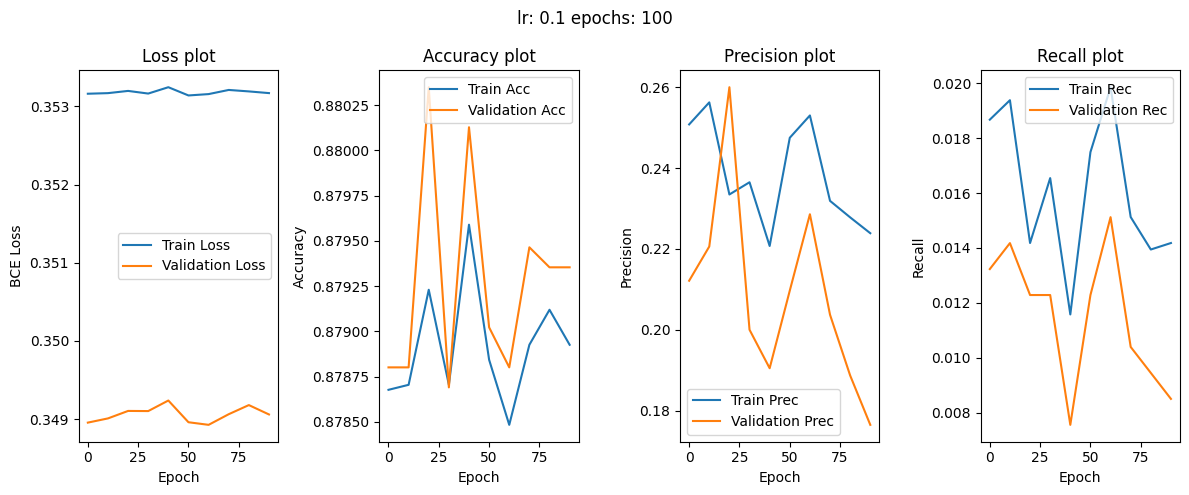

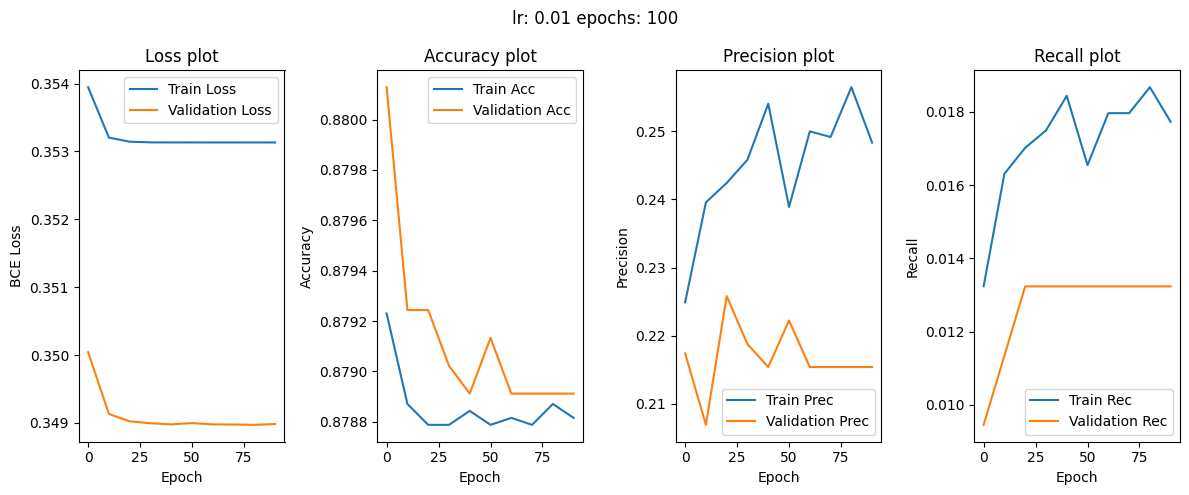

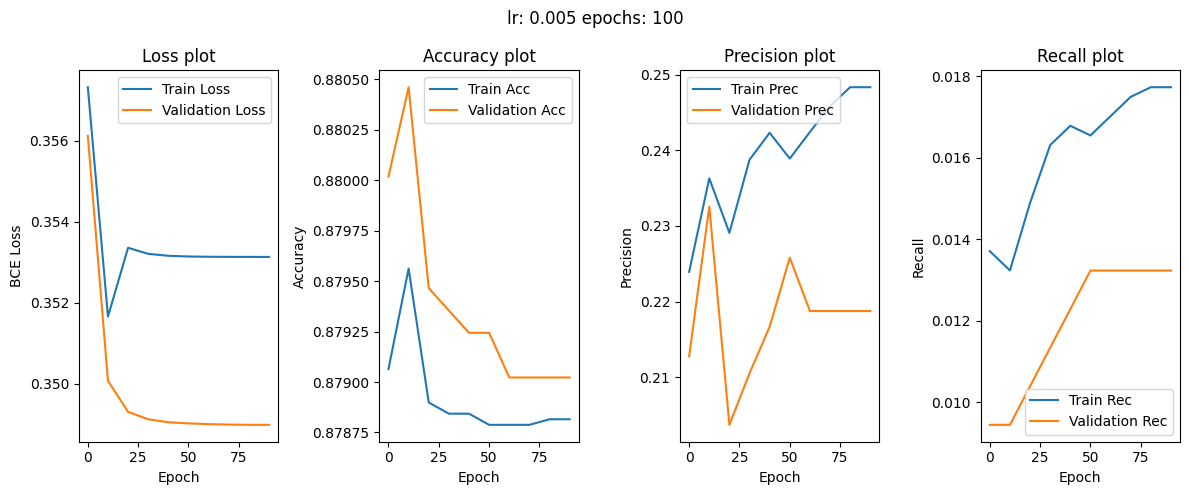

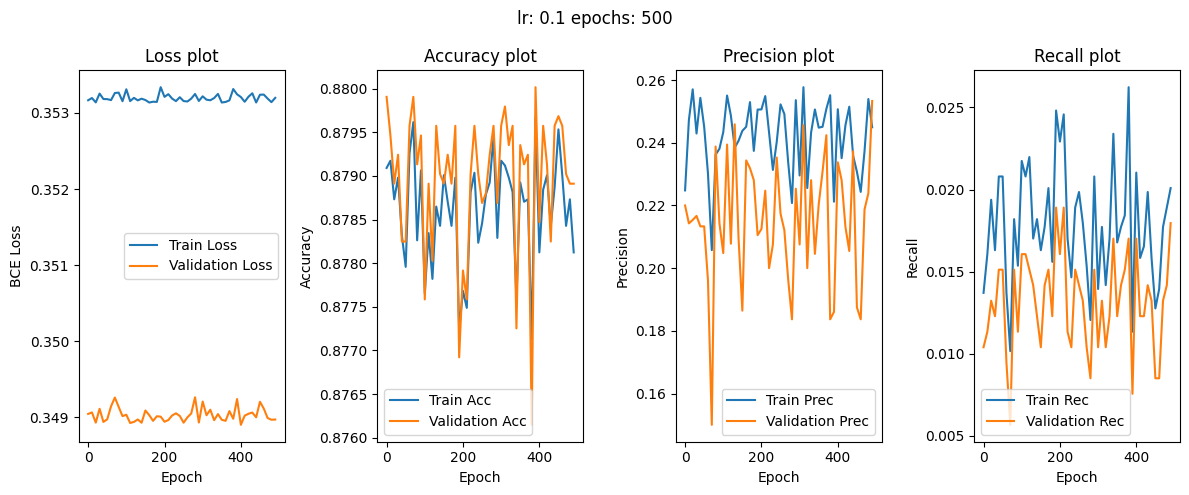

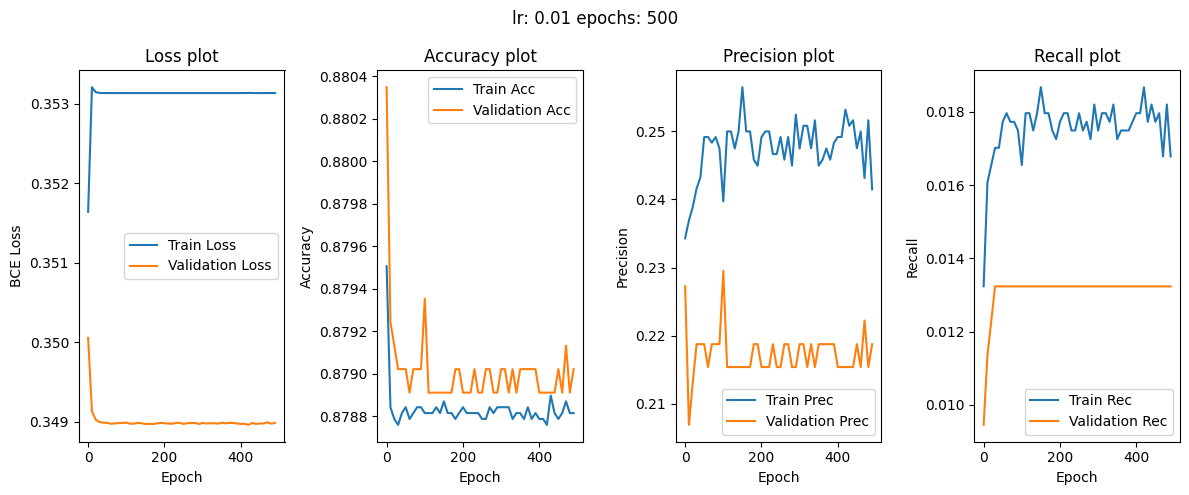

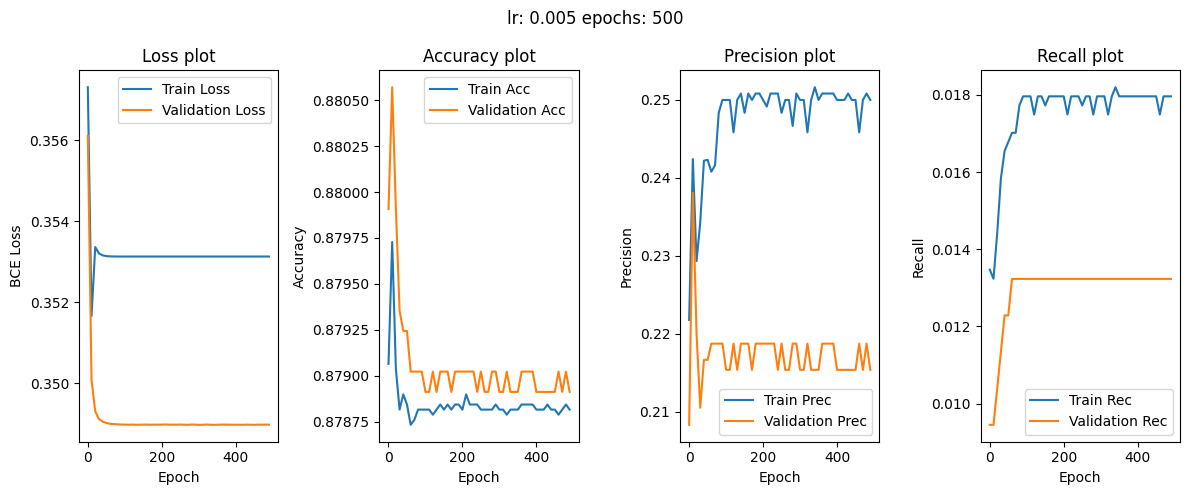

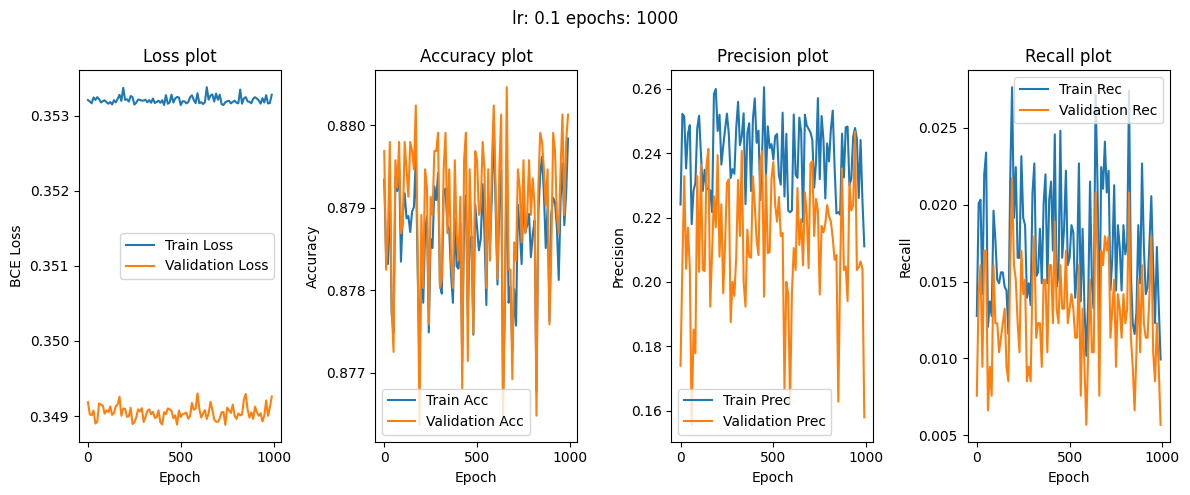

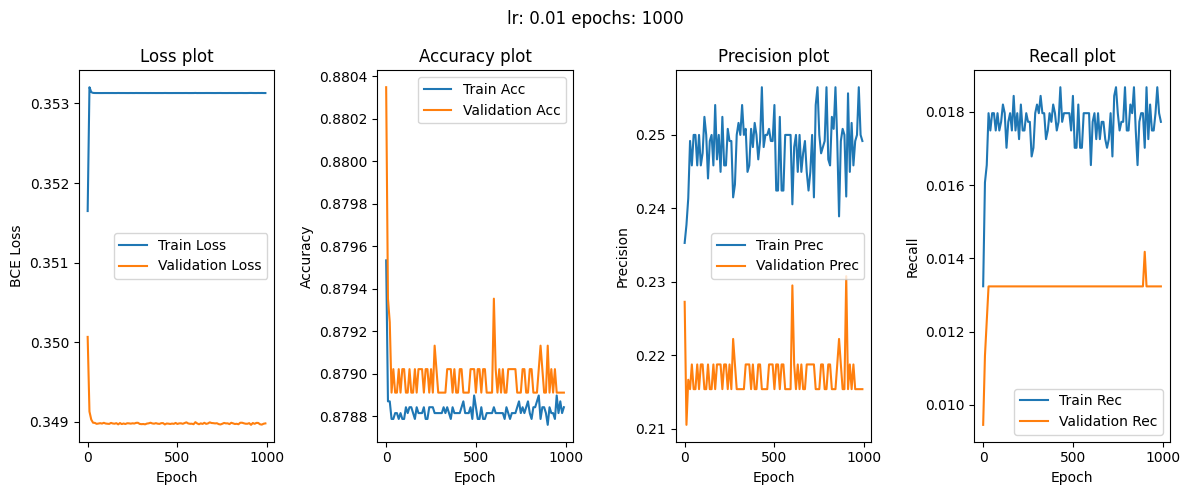

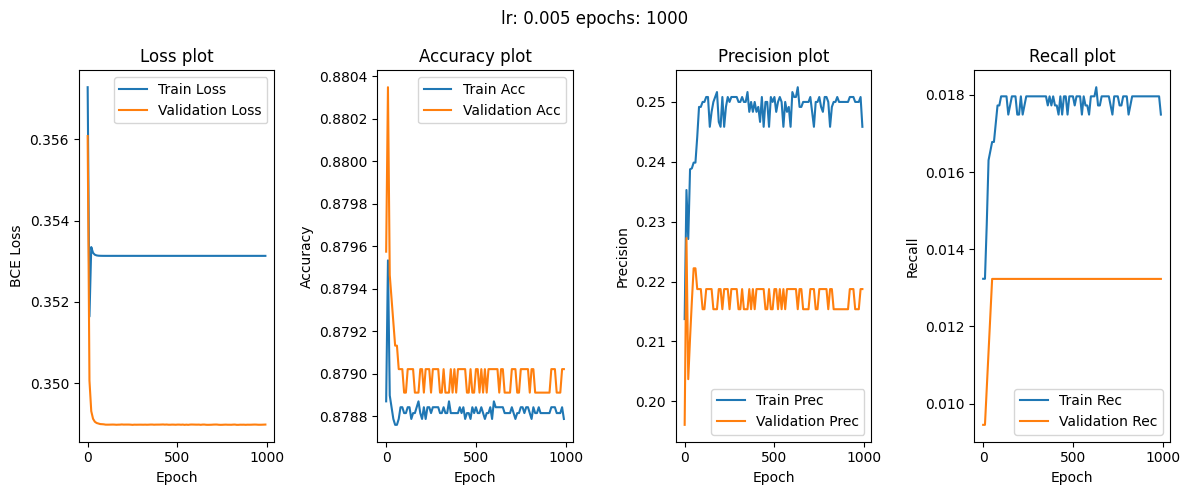

In [12]:
def test(epochs, lr):
  for epoch in epochs:
    for l in lr:
      perceptron = Perceptron(weight_count=5)

      trainer = Trainer(
          perceptron=perceptron,
          n_epochs=epoch,
          lr=l
      )

      trainer.train(X_train, y_train, X_test, y_test)
      #print(np.sum(trainer.predict(X_test) == 1))
      trainer.plot_metrics()

lr_list = [0.1, 0.01, 0.005]
epoch_list = [100, 500, 1000]

test(epoch_list, lr_list)

Perceptron w Torchu na ogół dawał trochę lepsze wyniki. U mnie działał jednak zdecydowanie wolniej niż w numpy, ale to chyba tylko dlatego, że nie mam karty graficznej w laptopie.


<span style="color:red">brakuje mie trochę zabawy z optimizerami</span>
<br>
<span style="color:red">Tak to ogólnie wszystko raczej git moze przy lepszem EDE poczatkowym uzyskałbyś lepsze wyniki sieci i faktyczne chocia dziesięten zmiany </span>


### Taki smaczek

Perceptron wg. Nano Banana. Co poszło źle?


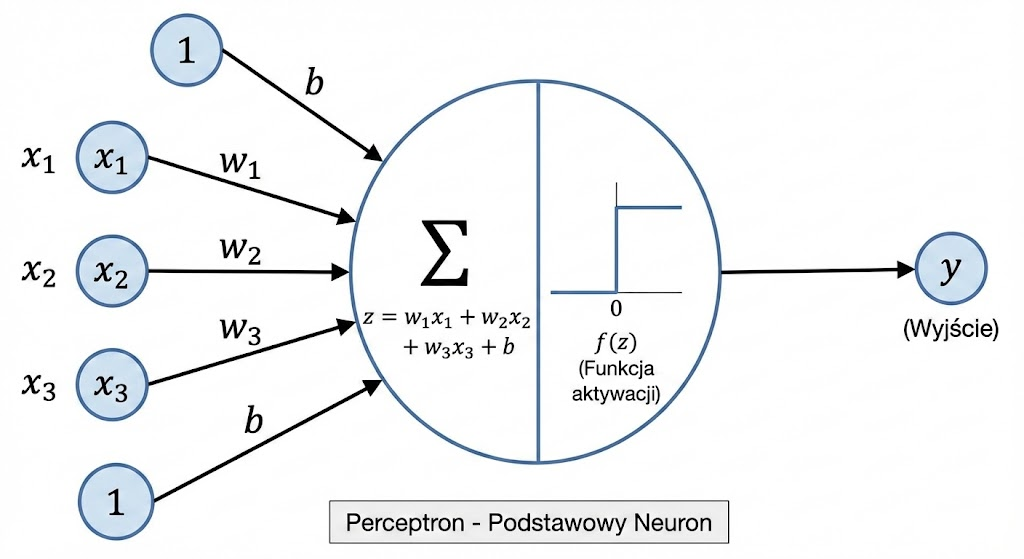